In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

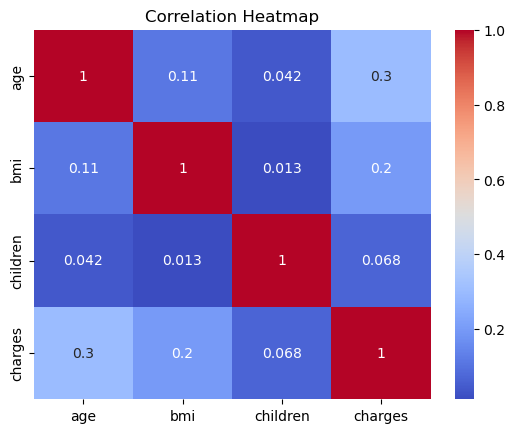

In [169]:
# Load dataset
data = pd.read_csv("C:/Users/Vaishnavi Kulkarni/Documents/IE 500 Stastical Machine Learning/Health_insurance.csv")

# Overview
print(data.info())
print(data.describe())
print(data.head())

# Filter numeric columns for correlation analysis
numeric_data = data.select_dtypes(include=[np.number])

# Correlation heatmap
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

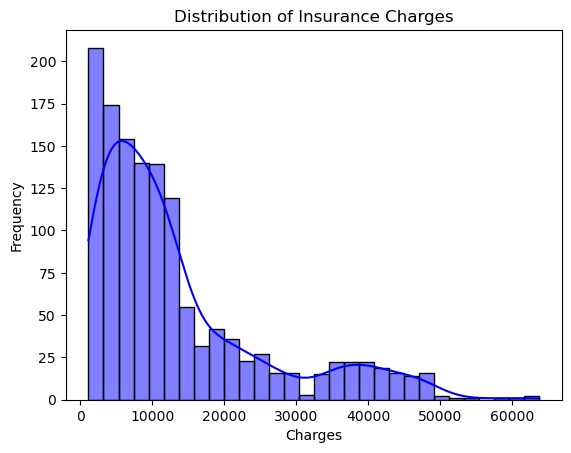

In [133]:
sns.histplot(data['charges'], kde=True, color='blue')
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

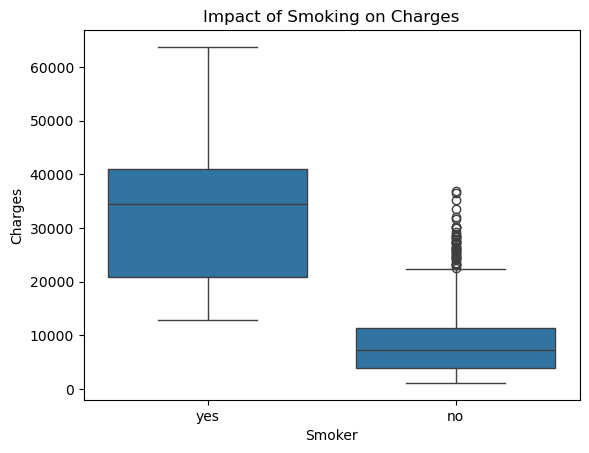

In [135]:
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('Impact of Smoking on Charges')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.show()

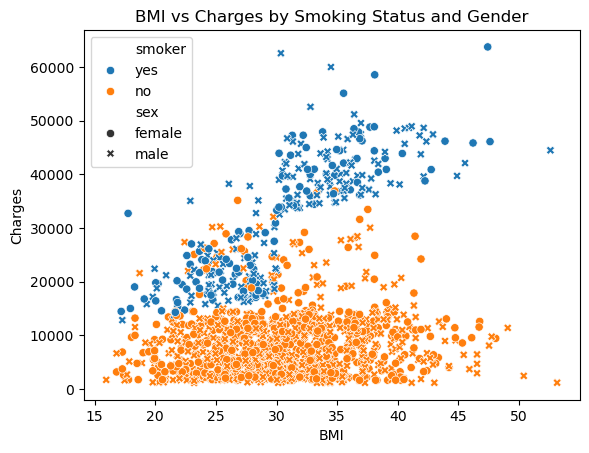

In [137]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', style='sex', data=data)
plt.title('BMI vs Charges by Smoking Status and Gender')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

In [171]:
# Split the data into features (X) and target (y)
X = data.drop(columns=['charges'])  # Features (excluding 'charges')
y = data['charges']  # Target (insurance charges)

# Define the preprocessing for numeric and categorical data
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Apply transformations to each feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

In [141]:
# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output dataset shapes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 1070 samples
Testing set size: 268 samples


In [173]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

# Print RMSE scores from cross-validation
print(f"Cross-validation RMSE scores: {-cv_scores}")
print(f"Average RMSE across folds: {-cv_scores.mean()}")

Cross-validation RMSE scores: [22446373.51382653 28945532.90278041 19056449.32502298 25496557.79877909
 22535802.45603657]
Average RMSE across folds: 23696143.199289113


In [175]:
# Linear Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline
lr_pipeline.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Performance Metrics
rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Linear Regression Performance:
RMSE: 5796.28
R²: 0.78


C:\Programming for Analytics\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [177]:
# Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit the pipeline
rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Performance Metrics
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
r2 = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Random Forest Performance:
RMSE: 4567.78
R²: 0.87


C:\Programming for Analytics\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\Vaishnavi Kulkarni\AppData\Local\Temp\ipykernel_4784\942054539.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


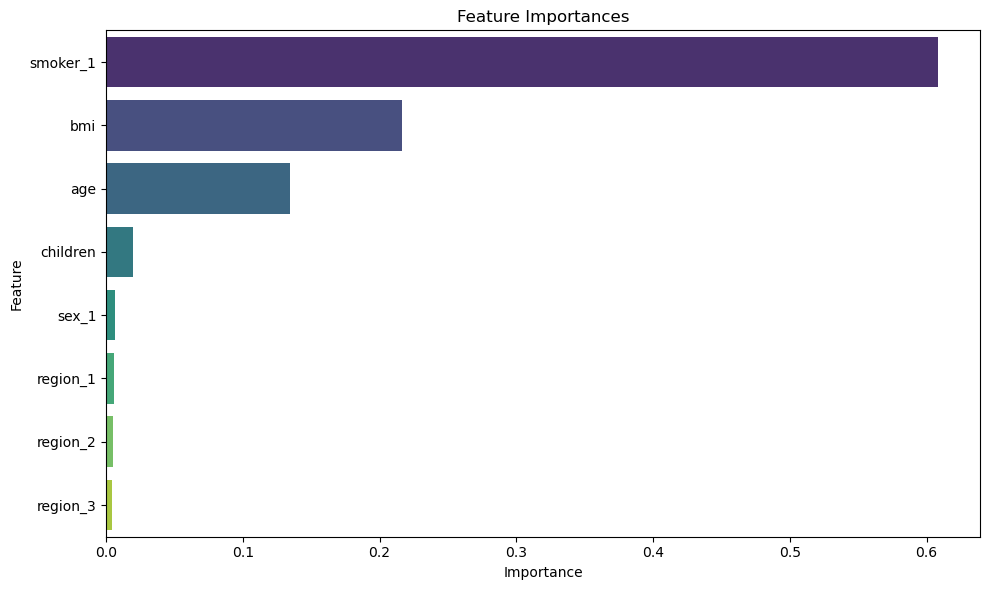

In [179]:
rf_pipeline.fit(X_train, y_train)
importances = rf_pipeline.named_steps['regressor'].feature_importances_
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
# Create a DataFrame for better handling
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importances_df, 
    palette='viridis'
)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [181]:
# Define the pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)
print("\nXGBoost Performance:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_xgb, squared=False):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred_xgb):.2f}")


XGBoost Performance:
RMSE: 4517.29
R2 Score: 0.87


C:\Programming for Analytics\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

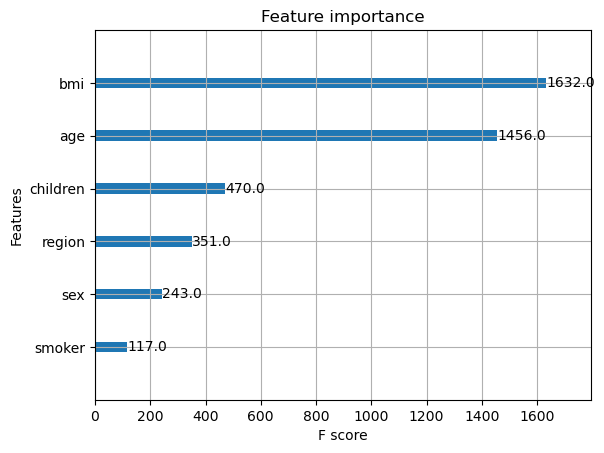

In [183]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance

# Encode categorical columns
label_encoders = {}
for col in ['sex', 'smoker', 'region']:
    label_encoders[col] = LabelEncoder()
    X_train[col] = label_encoders[col].fit_transform(X_train[col])
    X_test[col] = label_encoders[col].transform(X_test[col])

# Train the XGBRegressor model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Plot feature importance
plot_importance(xgb_model, importance_type='weight', max_num_features=10)

In [167]:
# Random Forest Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Evaluate tuned Random Forest
y_pred_best_rf = best_rf.predict(X_test)
print("\nTuned Random Forest Performance:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_best_rf, squared=False):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred_best_rf):.2f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_d

C:\Programming for Analytics\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


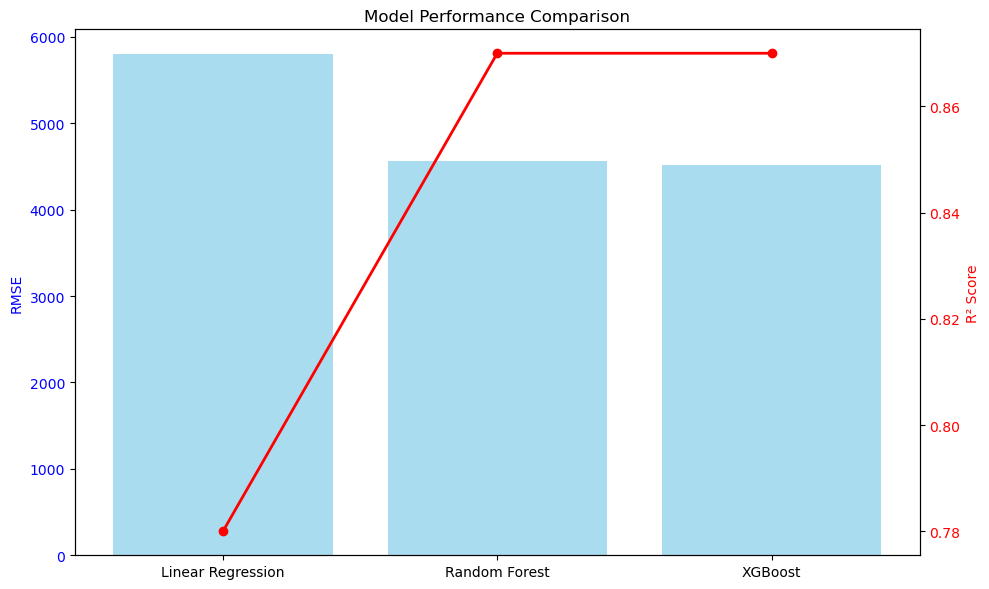

In [185]:
models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_scores = [5796.28, 4567.96, 4517.29]
r2_scores = [0.78, 0.87, 0.87]

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for RMSE
ax1.bar(models, rmse_scores, color='skyblue', label='RMSE', alpha=0.7)
ax1.set_ylabel('RMSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a secondary y-axis for R²
ax2 = ax1.twinx()
ax2.plot(models, r2_scores, color='red', marker='o', label='R² Score', linewidth=2)
ax2.set_ylabel('R² Score', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and legend
plt.title("Model Performance Comparison")
fig.tight_layout()
plt.show()

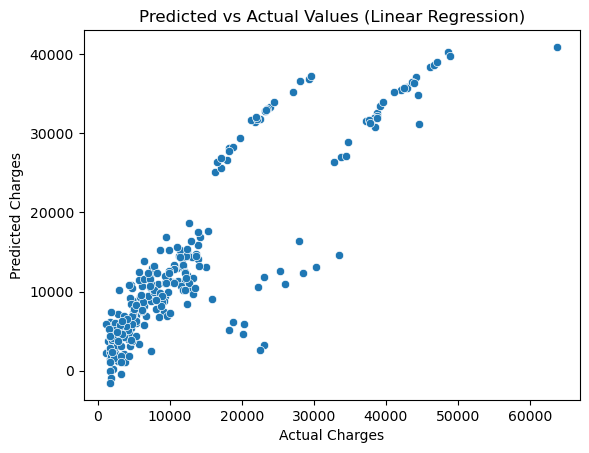

In [111]:
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.title('Predicted vs Actual Values (Linear Regression)')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.show()

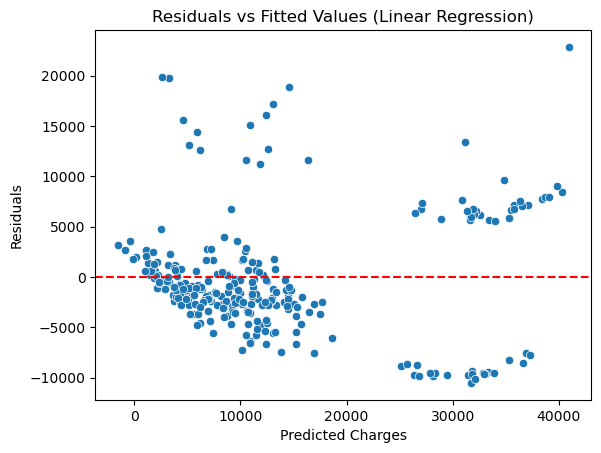

In [113]:
residuals_lr = y_test - y_pred_lr
sns.scatterplot(x=y_pred_lr, y=residuals_lr)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values (Linear Regression)')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.show()

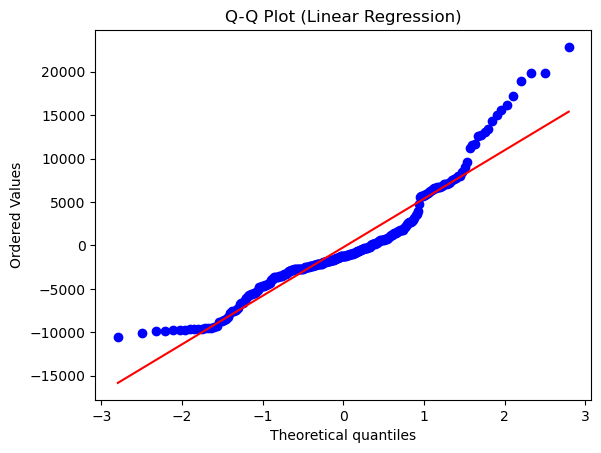

In [115]:
import scipy.stats as stats
stats.probplot(residuals_lr, dist="norm", plot=plt)
plt.title('Q-Q Plot (Linear Regression)')
plt.show()

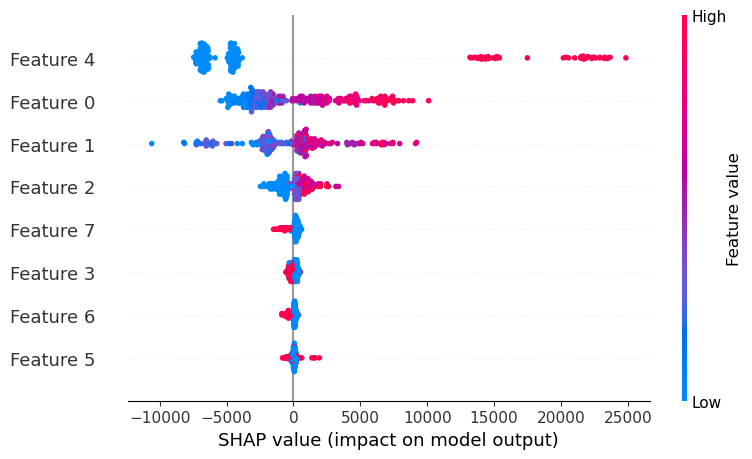

In [39]:
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)

In [187]:
print("Project Complete. Advanced models trained, evaluated, and interpreted successfully.")

Project Complete. Advanced models trained, evaluated, and interpreted successfully.
